In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
dropout = 0.5
epochs = 50
batch_size = 128
learning_rate=0.001
k = 5

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler 
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import plot_confusion_matrix ,roc_auc_score, roc_curve,auc
from sklearn.metrics import classification_report
import itertools
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import itertools
from scipy import interp
from itertools import cycle


In [4]:
def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [5]:
class Fold:
    def __init__(self):
        self.train_loss      = []
        self.train_accuracy  = [] 
        self.test_loss       = []
        
        self.test_accuracy   = []
        self.test_precision  = []
        self.test_recall     = []
        self.test_f1_score   = []
        
        self.major_accuracy  = 0
        
        
        self.last_pred       = np.array([], dtype=int) 
        self.last_true       = np.array([], dtype=int) 
        self.last_score      = np.array([]) 

        
        self.accuracy  = 0.
        self.precision = 0.
        self.recall    = 0.
        self.f1        = 0.
       
        self.confusion_matrix=[]


In [6]:
class DenseNeuralNetwork(nn.Module):
    def __init__(self):
        super(DenseNeuralNetwork, self).__init__()
        
        self.dense1 = nn.Sequential(
            nn.Linear(n_previsores, n_hiden),
            nn.BatchNorm1d(n_hiden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.dense2 = nn.Sequential(
            nn.Linear(n_hiden, n_hiden),
            nn.BatchNorm1d(n_hiden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.dense3 = nn.Linear(n_hiden, n_classes)

    def forward(self, X):
        X = self.dense1(X)
        X = self.dense2(X)
        X = self.dense3(X)
        return X

In [7]:
class Cnn1dNeuralNetwork(nn.Module):
    def __init__(self):
        super(Cnn1dNeuralNetwork, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, out_channels = 16,  kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            #nn.Dropout(dropout),            
            nn.MaxPool1d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(16,32 , kernel_size=3, stride=1, padding=1),            
            nn.BatchNorm1d(32),
            nn.ReLU(),
            #nn.Dropout(dropout),            
            nn.MaxPool1d(2)
        )
     
        
        
        self.flatten1 = nn.Flatten()

        self.dense1 = nn.Sequential( 
            nn.Linear(320, 230),
            nn.BatchNorm1d(230),
            nn.ReLU(),
            nn.Dropout(dropout)
        )   
        
        
        self.dense2 = nn.Sequential( 
            nn.Linear(230, 230),
            nn.BatchNorm1d(230),
            nn.ReLU(),
            nn.Dropout(dropout)
        )  
       
        self.dense3 = nn.Linear(230, n_classes)            

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.flatten1(X)
        X = self.dense1(X)
        X = self.dense2(X)
        X = self.dense3(X)
        return X

In [8]:
base = pd.read_csv('sdn_dataset_2022.csv',sep=';',usecols = 
                   
    [
    'forward_pl_mean','forward_piat_mean','forward_pps_mean','forward_bps_mean',
    'forward_pl_var','forward_piat_var','forward_pps_var','forward_bps_var',
    'forward_pl_q1','forward_pl_q3','forward_piat_q1','forward_piat_q3',
    'forward_pl_max','forward_pl_min','forward_piat_max','forward_piat_min',
    'forward_pps_max','forward_pps_min','forward_bps_max','forward_bps_min',
    'reverse_pl_mean','reverse_piat_mean','reverse_pps_mean','reverse_bps_mean',
    'reverse_pl_var','reverse_piat_var','reverse_pps_var','reverse_bps_var',
    'reverse_pl_q1','reverse_pl_q3','reverse_piat_q1','reverse_piat_q3',
    'reverse_pl_max','reverse_pl_min','reverse_piat_max','reverse_piat_min',
    'reverse_pps_max','reverse_pps_min','reverse_bps_max','reverse_bps_min',
    'category'
   ])

base = base[base.category.isin([
    'CHAT-ICQ',
    'CHAT-GMAIL',
    'CHAT-FACEBOOK',
    'CHAT-HANGOUTS',
    
    'FILE-SFTP-DOWN',
    'FILE-SKYPE',
    'FILE-FTPS',
    
    'STR-SPOTIFY',
    'STR-VIMEO',
    'STR-YOUTUBE',
    'STR-NETFLIX', 
    
    'VIDEO-SKYPE',
    'VIDEO-HANGOUTS',
    
    'AUDIO-VOIPBUSTER',
    'AUDIO-SKYPE',
    'AUDIO-HANGOUTS',
    'AUDIO-FACEBOOK',
    'EMAIL',
    
])]

In [9]:
base.shape

(5976, 41)

In [10]:
base = shuffle(base)
base.head()

,forward_pl_mean,forward_piat_mean,forward_pps_mean,forward_bps_mean,forward_pl_var,forward_piat_var,forward_pps_var,forward_bps_var,forward_pl_q1,forward_pl_q3,...,reverse_piat_q3,reverse_pl_max,reverse_pl_min,reverse_piat_max,reverse_piat_min,reverse_pps_max,reverse_pps_min,reverse_bps_max,reverse_bps_min,category
4709,158.533654,0.018450,54.299923,8689.125598,1149.529370,5.113206e-07,6.756934,7.785510e+06,153.020305,153.860595,...,0.044862,261.697095,132.947368,0.050474,0.037709,26.518900,19.812304,6698.100139,2633.993743,AUDIO-HANGOUTS
1558,77.720086,0.002838,425.779495,31045.329886,155.964224,1.725103e-06,27230.267286,6.484354e+07,66.861377,86.001404,...,0.009472,1076.666667,404.415842,0.011634,0.006995,142.956418,85.957447,153916.410205,34762.553191,FILE-SFTP-DOWN
1103,66.437492,0.099435,16.688310,1110.463239,0.394601,2.750041e-02,28.576721,1.305659e+05,66.000000,66.684089,...,0.027606,1506.894895,578.000000,0.855000,0.015122,66.130474,1.169591,99651.673121,676.023392,STR-VIMEO
2898,474.775715,0.018662,96.343415,44675.647755,7225.461597,9.397710e-04,686.508145,1.397273e+08,456.895594,460.521989,...,0.006089,869.410163,62.000000,0.125000,0.005714,175.009893,8.000000,150749.901068,496.000000,VIDEO-SKYPE
3926,136.602689,0.070683,48.134939,6687.119286,261.457732,1.496455e-01,99.562463,2.228642e+06,132.093069,141.615164,...,0.020026,159.648915,60.571429,5.048000,0.018871,52.991284,0.198098,8374.231913,12.083994,AUDIO-SKYPE


In [11]:
base_columns= len(base.columns)-1
previsores = base.iloc[ :, :base_columns]
classe = base.iloc[ :, base_columns]

In [12]:
previsores

,forward_pl_mean,forward_piat_mean,forward_pps_mean,forward_bps_mean,forward_pl_var,forward_piat_var,forward_pps_var,forward_bps_var,forward_pl_q1,forward_pl_q3,...,reverse_piat_q1,reverse_piat_q3,reverse_pl_max,reverse_pl_min,reverse_piat_max,reverse_piat_min,reverse_pps_max,reverse_pps_min,reverse_bps_max,reverse_bps_min
4709,158.533654,0.018450,54.299923,8689.125598,1149.529370,5.113206e-07,6.756934,7.785510e+06,153.020305,153.860595,...,0.040658,0.044862,261.697095,132.947368,0.050474,0.037709,26.518900,19.812304,6698.100139,2633.993743
1558,77.720086,0.002838,425.779495,31045.329886,155.964224,1.725103e-06,27230.267286,6.484354e+07,66.861377,86.001404,...,0.007294,0.009472,1076.666667,404.415842,0.011634,0.006995,142.956418,85.957447,153916.410205,34762.553191
1103,66.437492,0.099435,16.688310,1110.463239,0.394601,2.750041e-02,28.576721,1.305659e+05,66.000000,66.684089,...,0.019600,0.027606,1506.894895,578.000000,0.855000,0.015122,66.130474,1.169591,99651.673121,676.023392
2898,474.775715,0.018662,96.343415,44675.647755,7225.461597,9.397710e-04,686.508145,1.397273e+08,456.895594,460.521989,...,0.005949,0.006089,869.410163,62.000000,0.125000,0.005714,175.009893,8.000000,150749.901068,496.000000
3926,136.602689,0.070683,48.134939,6687.119286,261.457732,1.496455e-01,99.562463,2.228642e+06,132.093069,141.615164,...,0.019868,0.020026,159.648915,60.571429,5.048000,0.018871,52.991284,0.198098,8374.231913,12.083994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3262,1003.220852,0.018884,388.810337,393247.803875,4105.362852,8.263340e-03,6909.275173,8.406115e+09,1016.815888,1020.958867,...,0.005871,0.006125,665.052863,76.000000,0.484000,0.005234,191.075855,2.066116,113278.750124,157.024793
1060,69.374178,0.048504,22.609109,1594.732443,242.054271,8.936530e-05,137.095683,9.664321e+05,66.021978,66.630000,...,0.015238,0.024087,1739.500000,1479.383178,0.087000,0.006950,143.891313,11.494253,214912.138040,19994.252874
4161,136.704538,0.071989,48.070212,6686.293291,267.720751,1.534143e-01,101.929843,2.285249e+06,132.115516,141.632003,...,0.019869,0.020027,159.648915,60.571429,5.048000,0.018871,52.991284,0.198098,8374.231913,12.083994
260,482.595292,3.917572,153.424011,158590.843778,383507.372546,1.756704e+01,32733.238401,5.659599e+10,60.000000,1411.510756,...,0.002712,10.080000,1411.911471,60.000000,10.125000,0.002483,402.795678,0.098765,532898.645308,5.925926


In [13]:
classe_label = np.unique(base['category'])
len(classe_label)
classe_label

array(['AUDIO-FACEBOOK', 'AUDIO-HANGOUTS', 'AUDIO-SKYPE',
       'AUDIO-VOIPBUSTER', 'CHAT-FACEBOOK', 'CHAT-GMAIL', 'CHAT-HANGOUTS',
       'CHAT-ICQ', 'EMAIL', 'FILE-FTPS', 'FILE-SFTP-DOWN', 'FILE-SKYPE',
       'STR-NETFLIX', 'STR-SPOTIFY', 'STR-VIMEO', 'STR-YOUTUBE',
       'VIDEO-HANGOUTS', 'VIDEO-SKYPE'], dtype=object)

[Text(0.5, 0, 'Classes'), Text(0, 0.5, 'Quantity')]

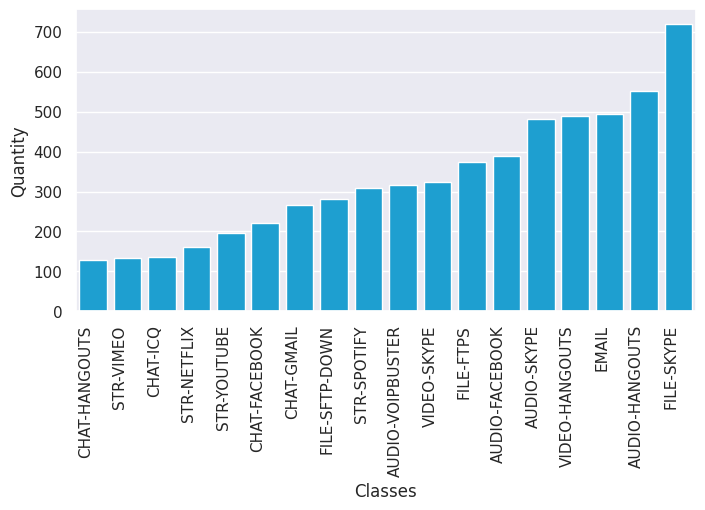

In [15]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})

ax=plt.subplots(figsize = (8,4))
ax=sns.countplot(x=base["category"], 
                 orient="V",
                  palette=["#00ACEE"],
                 
                 order=base['category'].value_counts( ).sort_values().index
                )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

ax.set(xlabel='Classes', ylabel='Quantity')

In [16]:
encoder = LabelEncoder()
classe = encoder.fit_transform(classe)

In [17]:
scaler = StandardScaler()
previsores = scaler.fit_transform(previsores)

In [19]:
n_previsores=np.shape(previsores)[1]
n_classes = len(np.unique(classe))
n_hiden=int((np.shape(previsores)[1] + len(np.unique(classe)))/2)

In [20]:
print(n_previsores,n_hiden,n_classes)

40 29 18


In [21]:
model = Cnn1dNeuralNetwork()

In [22]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = learning_rate,
    weight_decay = 0.0001
                      )

In [23]:
kf = KFold(n_splits=k, random_state=None)

accuracy_stack = np.array([], dtype=int) 
precision_stack = np.array([], dtype=int) 
recall_stack = np.array([], dtype=int) 
f1_score_stack = np.array([], dtype=int) 

matriz_score = []

train_accu=[]
train_loss=[]

test_accu=[]
test_loss=[]

In [24]:
device='cpu'
print(device)
model.to(device)

cpu


Cnn1dNeuralNetwork(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (dense1): Sequential(
    (0): Linear(in_features=320, out_features=230, bias=True)
    (1): BatchNorm1d(230, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (dense2): Sequential(
    (0): Linear(in_features=230, out_features=230, bias=True)
    (1): BatchNorm1d(230, eps=1e-05, moment

In [25]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("darkgrid")

In [26]:
folds=[]
y_score = np.empty((0,n_classes), float)
y_true  = np.array([], dtype=int) 
y_pred  = np.array([], dtype=int) 

for i in range(k):
    folds.append(Fold())


j=0

start_time = time.perf_counter()

for train_index , test_index in kf.split(previsores):
    
    previsores_treinamento, previsores_teste = previsores[train_index,:], previsores[test_index,:]
    classe_treinamento, classe_teste = classe[train_index] , classe[test_index]
    
    previsores_treinamento = torch.tensor(previsores_treinamento, dtype=torch.float)
    classe_treinamento = torch.tensor(classe_treinamento, dtype=torch.long)
    
    previsores_teste = torch.tensor(previsores_teste, dtype=torch.float)
    classe_teste = torch.tensor(classe_teste, dtype=torch.long)
    
    train_dataset = torch.utils.data.TensorDataset(previsores_treinamento, classe_treinamento)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True,drop_last=True)
    
    test_dataset = torch.utils.data.TensorDataset(previsores_teste, classe_teste)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True,drop_last=True)
        
    for epoch in range(epochs):
        
        model.train()
        
        running_loss = 0.
        running_accuracy = 0.
      
        for data in train_loader:
            
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)
            inputs = inputs.unsqueeze(1)
            
           
            optimizer.zero_grad()

           
            outputs = model.forward(inputs)
        
           
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            
            
            outputs = F.softmax(outputs)
             
            
            
            top_p, top_class = outputs.topk(k = 1, dim = 1)
    
            equals = top_class == labels.view(*top_class.shape)
    
            running_accuracy += torch.mean(equals.type(torch.float)).item()
            
        
            optimizer.step()
        
           
            running_loss += loss.item()
        
           
            outputs = [np.argmax(t) for t in outputs.detach().cpu().numpy()]

        
        folds[j].train_accuracy.append(running_accuracy/len(train_loader))
        folds[j].train_loss.append(running_loss/len(train_loader))

        
        model.eval()
    
        running_loss = 0.
        running_accuracy = 0.
    
        for data in test_loader:
           
         
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)
      
    
            outputs = model.forward(inputs)
        
            loss = criterion(outputs, labels)

            
            outputs = F.softmax(outputs)

            y_score = np.vstack((y_score, outputs.detach().numpy()))
           
            y_true   =  np.concatenate((y_true ,[np.argmax(t) for t in outputs.detach().cpu().numpy()]))
           
            y_pred  =  np.concatenate((y_pred, labels.detach().cpu().numpy()))
            
           
            top_p, top_class = outputs.topk(k = 1, dim = 1)
    
            equals = top_class == labels.view(*top_class.shape)
    
            running_accuracy += torch.mean(equals.type(torch.float)).item()
            
            running_loss += loss.item()
        
        folds[j].test_loss.append(running_loss/len(test_loader))
        
        folds[j].test_accuracy.append(running_accuracy/len(test_loader))
        folds[j].test_precision.append(precision_score( y_true, y_pred,average='macro'))
        folds[j].test_recall.append(recall_score( y_true, y_pred,average='macro'))
        folds[j].test_f1_score.append(f1_score( y_true, y_pred,average='macro'))
    
 
        
        color_text = "\33[30m"
        if ((epoch == 0) or (folds[j].test_accuracy[-1] > folds[j].major_accuracy)):
            color_text = "\33[34m"
            folds[j].major_accuracy = folds[j].test_accuracy[-1]
       

    
      
        folds[j].last_score = y_score
        folds[j].last_true = y_true
        folds[j].last_pred= y_pred
        
        
        
        y_true  = np.array([], dtype=int) 
        y_pred  = np.array([], dtype=int)
        y_score = np.empty((0,n_classes), float)
        
       
#        print('%s(%2d|%3d): Train[Loss: %.5f|Acc: %.5f] Test[Loss: %.5f|Acc: %.5f|Pre: %.5f|Rec: %.5f|F1: %.5f]\033[m' % (
        print('%s(%2d|%3d): %.10f;%.10f;%.10f;%.10f\033[m' % (

            color_text,
            j+1,
            epoch + 1,
           
            folds[j].test_accuracy[-1],
            folds[j].test_precision[-1],
            folds[j].test_recall[-1],
            folds[j].test_f1_score[-1],
        ))
        
        
   
    j+=1
    
   
    model.apply(weight_reset)
    
end_time = time.perf_counter()

( 1|  1): 0.6901041667;0.6071154472;0.7243335143;0.5777899877
( 1|  2): 0.8602430556;0.8065467776;0.8556448555;0.7920555501
( 1|  3): 0.9296875000;0.8984305829;0.9039377262;0.8940836753
( 1|  4): 0.9331597222;0.9007980181;0.9063528023;0.8969733468
( 1|  5): 0.9435763889;0.9159659544;0.9265003984;0.9122102112
( 1|  6): 0.9592013889;0.9375554865;0.9442269690;0.9383347863
( 1|  7): 0.9557291667;0.9355398549;0.9372593438;0.9318467958
( 1|  8): 0.9609375000;0.9395469501;0.9496221309;0.9427189387
( 1|  9): 0.9600694444;0.9370840652;0.9471378286;0.9387018358
( 1| 10): 0.9583333333;0.9418259716;0.9487119916;0.9443239811
( 1| 11): 0.9661458333;0.9486251967;0.9547241316;0.9494718556
( 1| 12): 0.9687500000;0.9506289105;0.9556909762;0.9511585634
( 1| 13): 0.9739583333;0.9598071054;0.9662808570;0.9618583691
( 1| 14): 0.9678819444;0.9505438791;0.9538946883;0.9501617748
( 1| 15): 0.9722222222;0.9603685507;0.9667027538;0.9627643930
( 1| 16): 0.9730902778;0.9550945820;0.9606969056;0.9572661834
( 1| 17)

( 3| 19): 0.9722222222;0.9622421700;0.9727690013;0.9670081529
( 3| 20): 0.9722222222;0.9601280722;0.9730783179;0.9660635105
( 3| 21): 0.9748263889;0.9653298584;0.9755354576;0.9700267200
( 3| 22): 0.9739583333;0.9627390419;0.9723945261;0.9671973543
( 3| 23): 0.9739583333;0.9631869591;0.9722152729;0.9673003154
( 3| 24): 0.9730902778;0.9638439036;0.9737068897;0.9683997812
( 3| 25): 0.9713541667;0.9644610380;0.9688252661;0.9661796201
( 3| 26): 0.9765625000;0.9659050865;0.9772452921;0.9712349866
( 3| 27): 0.9730902778;0.9642361420;0.9734064276;0.9683744854
( 3| 28): 0.9739583333;0.9653938457;0.9749747953;0.9697074527
( 3| 29): 0.9722222222;0.9620366598;0.9711701396;0.9660850981
( 3| 30): 0.9748263889;0.9652647396;0.9744980987;0.9695442199
( 3| 31): 0.9748263889;0.9668018936;0.9746847985;0.9700811576
( 3| 32): 0.9748263889;0.9664087084;0.9748872564;0.9703177375
( 3| 33): 0.9765625000;0.9672608097;0.9742678386;0.9704708230
( 3| 34): 0.9765625000;0.9682898762;0.9757010548;0.9717699005
( 3| 35)

( 5| 37): 0.9765625000;0.9704965584;0.9680814442;0.9689555969
( 5| 38): 0.9791666667;0.9752480933;0.9739972796;0.9744823813
( 5| 39): 0.9791666667;0.9747242887;0.9725019225;0.9733590854
( 5| 40): 0.9782986111;0.9726171225;0.9734065196;0.9727653314
( 5| 41): 0.9756944444;0.9697925896;0.9675475304;0.9684601657
( 5| 42): 0.9756944444;0.9682234617;0.9650449629;0.9664594799
( 5| 43): 0.9756944444;0.9704340635;0.9695083844;0.9696482125
( 5| 44): 0.9809027778;0.9777410212;0.9745801968;0.9757512430
( 5| 45): 0.9774305556;0.9713857828;0.9698933052;0.9703024914
( 5| 46): 0.9704861111;0.9637093386;0.9634684813;0.9633451255
( 5| 47): 0.9774305556;0.9716938000;0.9695608929;0.9699483435
( 5| 48): 0.9774305556;0.9719621781;0.9714482634;0.9714438167
( 5| 49): 0.9756944444;0.9697303819;0.9662865289;0.9678342277
( 5| 50): 0.9748263889;0.9691080402;0.9679133760;0.9683104521


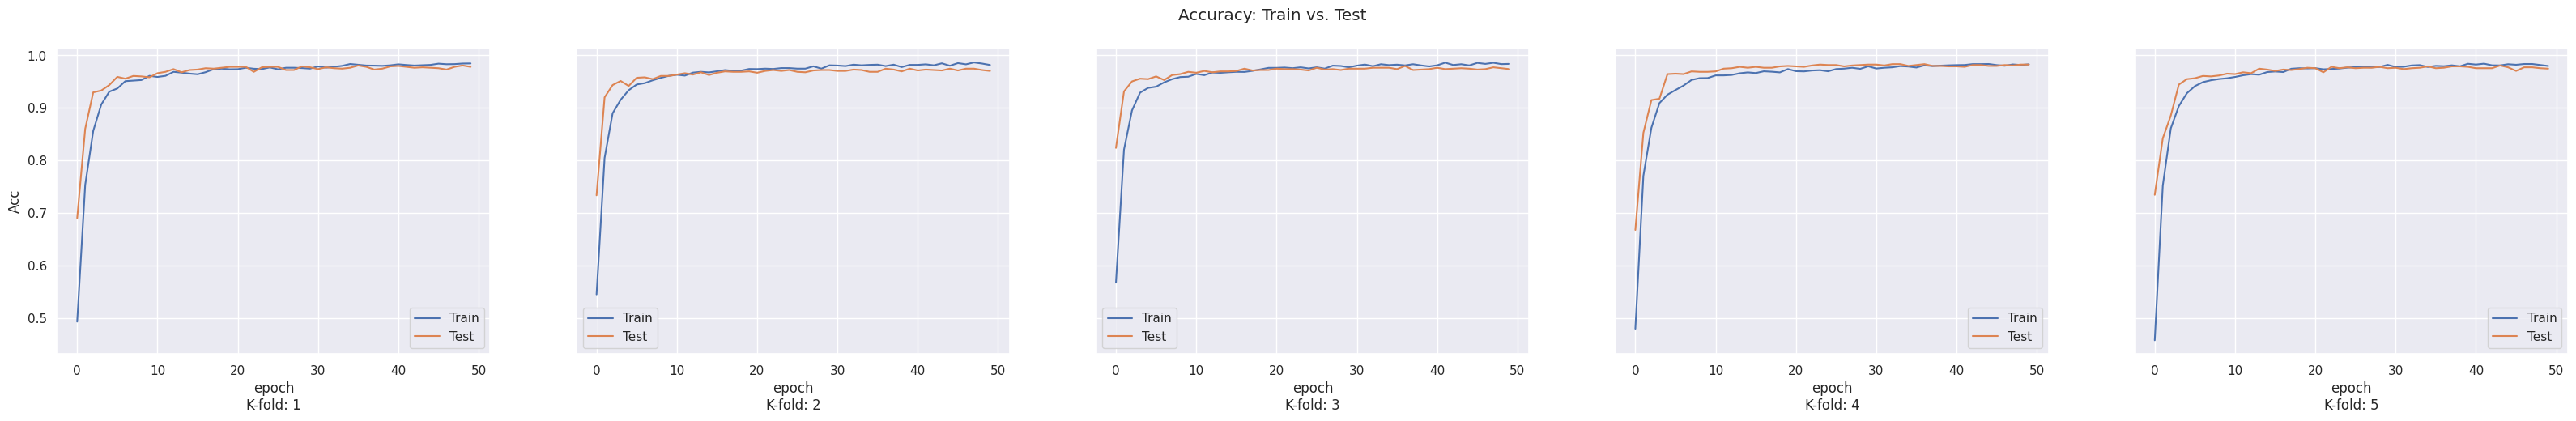

In [27]:
fig, axes = plt.subplots(1, k, figsize=(40, 5), sharey=True)
fig.suptitle('Accuracy: Train vs. Test')
i=0
for i in range(k):
    res= sns.lineplot(
            ax=axes[i],
            data=[folds[i].train_accuracy,
            folds[i].test_accuracy],
            markers=False, 
            dashes=False,   
            )
    res.set(xlabel='epoch\nK-fold: {:d}'.format(i+1), ylabel='Acc')
    res.legend(labels=["Train","Test"])   

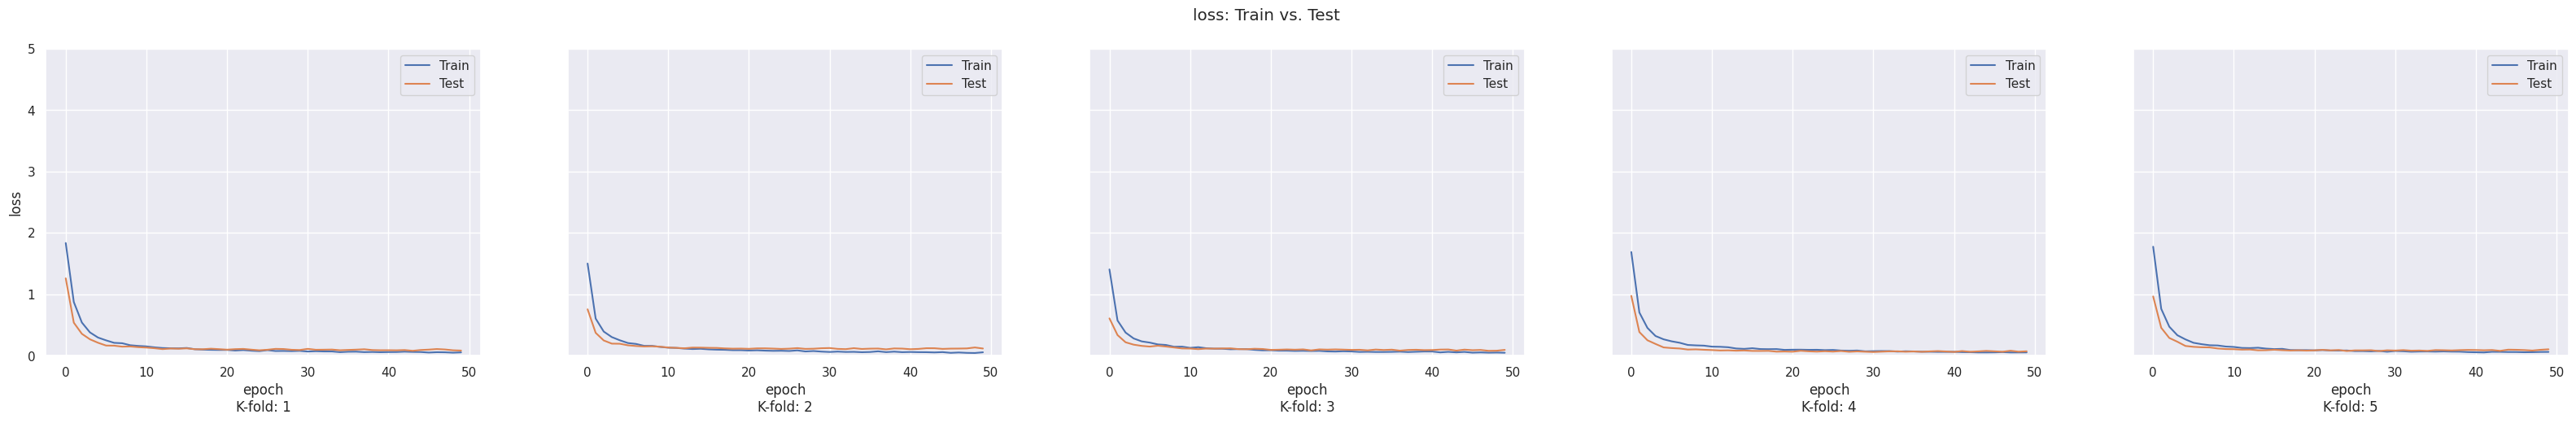

In [28]:
fig, axes = plt.subplots(1, k, figsize=(40, 5), sharey=True, sharex=True)
fig.suptitle('loss: Train vs. Test')
i=0
for i in range(k):
    res= sns.lineplot(
        ax=axes[i],
        data=[
            folds[i].train_loss,
            folds[i].test_loss],
        markers=False, 
        dashes=False    
        )

    res.set(xlabel='epoch\nK-fold: {:d}'.format(i+1), ylabel='loss')
    res.legend(labels=["Train","Test"])
    plt.ylim(0, 5)

In [29]:
for i in range(k):
    folds[i].confusion_matrix = confusion_matrix(folds[i].last_true, folds[i].last_pred)
    folds[i].accuracy = accuracy_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),normalize = True)
    folds[i].precision = precision_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),average='macro')
    folds[i].recall = recall_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),average='macro')
    folds[i].f1_score = f1_score( folds[i].last_true.reshape(-1), folds[i].last_pred.reshape(-1),average='macro')
    
    accuracy_stack = np.append(accuracy_stack,folds[i].accuracy) 
    precision_stack = np.append(accuracy_stack,folds[i].precision) 
    recall_stack = np.append(accuracy_stack,folds[i].recall) 
    f1_score_stack = np.append(accuracy_stack,folds[i].f1_score) 

    
  

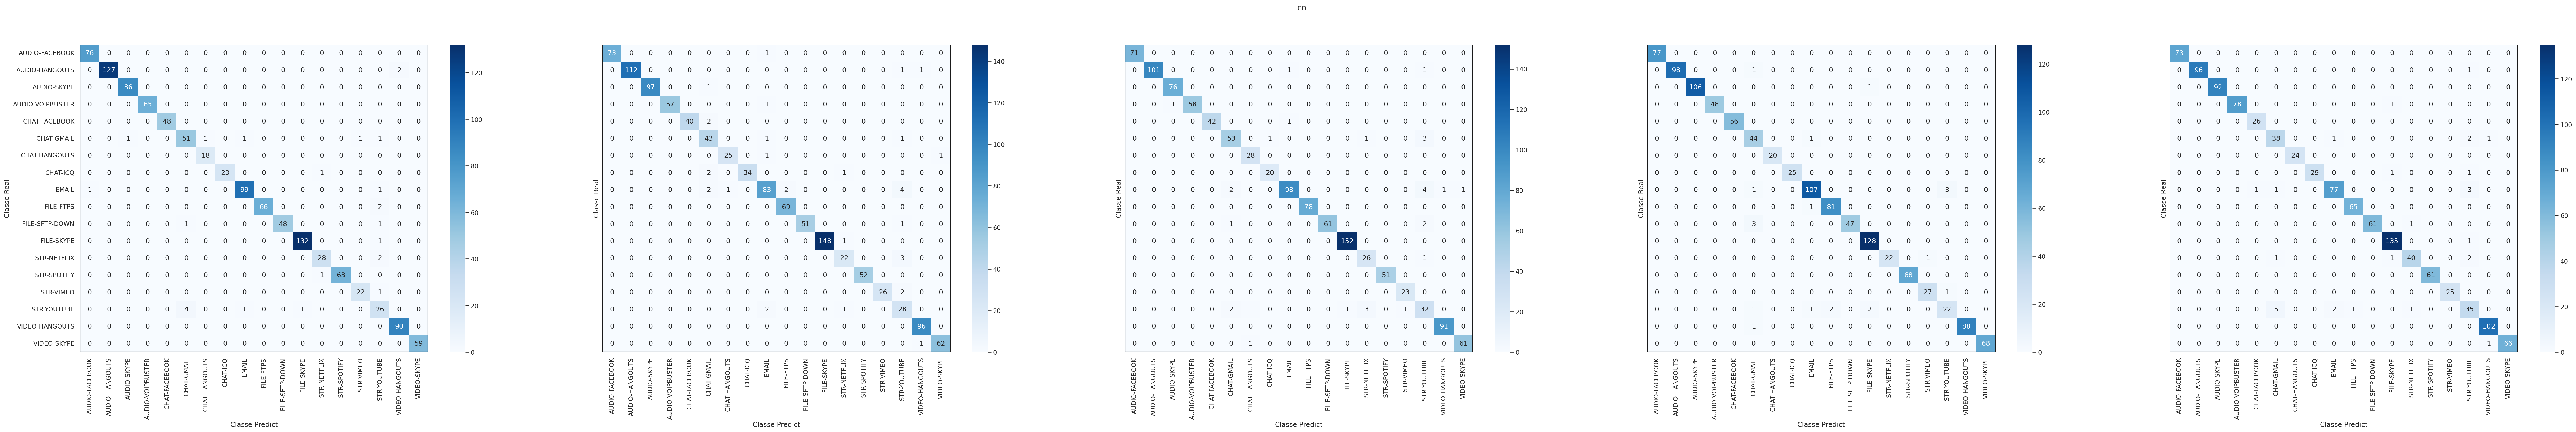

In [30]:
i=0
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("darkgrid")

fig, axes = plt.subplots(1, k, figsize=(80, 10), sharey=True)
fig.suptitle('co')

for i in range(k):
    res= sns.heatmap(folds[i].confusion_matrix,
                ax=axes[i],
                annot = True,
                linecolor='black',
                xticklabels=classe_label,
                yticklabels=classe_label,
                cmap="Blues" ,
                    fmt='g')
    res.set(xlabel='Classe Predict',ylabel='Classe Real')
    res.axhline(y = 0, color = 'k',linewidth = 2) 
    res.axhline(y = len(classe_label), color = 'k', linewidth = 2) 
    res.axvline(x = 0, color = 'k', linewidth = 2) 
    res.axvline(x = len(classe_label), color = 'k', linewidth = 2)

In [31]:
variancia = accuracy_stack.std() ** 2
print('training time + test: {0:.10f} sec'.format(end_time - start_time))
print('Variance'.format((variancia)))


print("Fold\tAcc.\tPrec\tRec\tF1-s")
for i in range(k):
    print("{:d}\t{:0.5f}\t{:0.5f}\t{:0.5f}\t{:0.5f}".format(i+1, folds[i].accuracy,folds[i].precision,folds[i].recall,folds[i].f1_score ))
    

training time + test: 124.4447997670 sec
Variance
Fold	Acc.	Prec	Rec	F1-s
1	0.97830	0.96763	0.96909	0.96815
2	0.97049	0.95943	0.95925	0.95821
3	0.97396	0.96123	0.97104	0.96572
4	0.98264	0.97772	0.97474	0.97588
5	0.97483	0.96911	0.96791	0.96831


In [32]:
matrizes = [] 
total_accuracy = []
total_precision = []
total_recall = []
total_f1_score = []

for i in range(k):
    matrizes.append(folds[i].confusion_matrix)
    total_accuracy.append( folds[i].accuracy)
    total_precision.append( folds[i].precision)
    total_recall.append( folds[i].recall)
    total_f1_score.append( folds[i].f1_score)

In [33]:
matriz_final = np.mean(matrizes, axis=0)


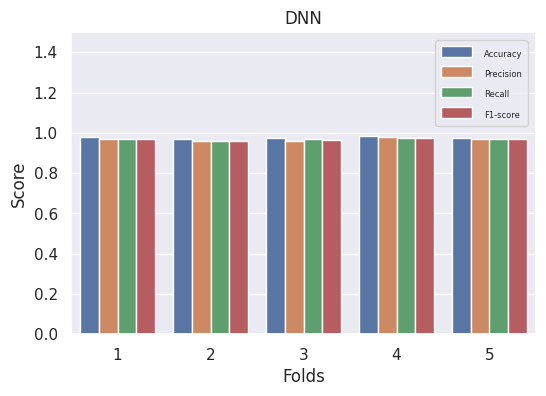

In [35]:
array = [] 
for i in range(k):
    array.append([i+1,folds[i].accuracy,'Accuracy'])
    array.append([i+1,folds[i].precision,'Precision'])
    array.append([i+1,folds[i].recall,'Recall'])
    array.append([i+1,folds[i].f1_score,'F1-score'])
    

column_values = ['fold','valor','metric']
df = pd.DataFrame(data = array,columns = column_values)

sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})


fig = sns.barplot(x='fold', y='valor', hue='metric', data=df)
plt.setp(fig.get_legend().get_texts(), fontsize='6') # for legend text
fig.legend_.set_title(None)

plt.xlabel("Folds")
plt.ylabel("Score")
plt.title("DNN") 
plt.ylim(0,1.5)

plt.show(fig)


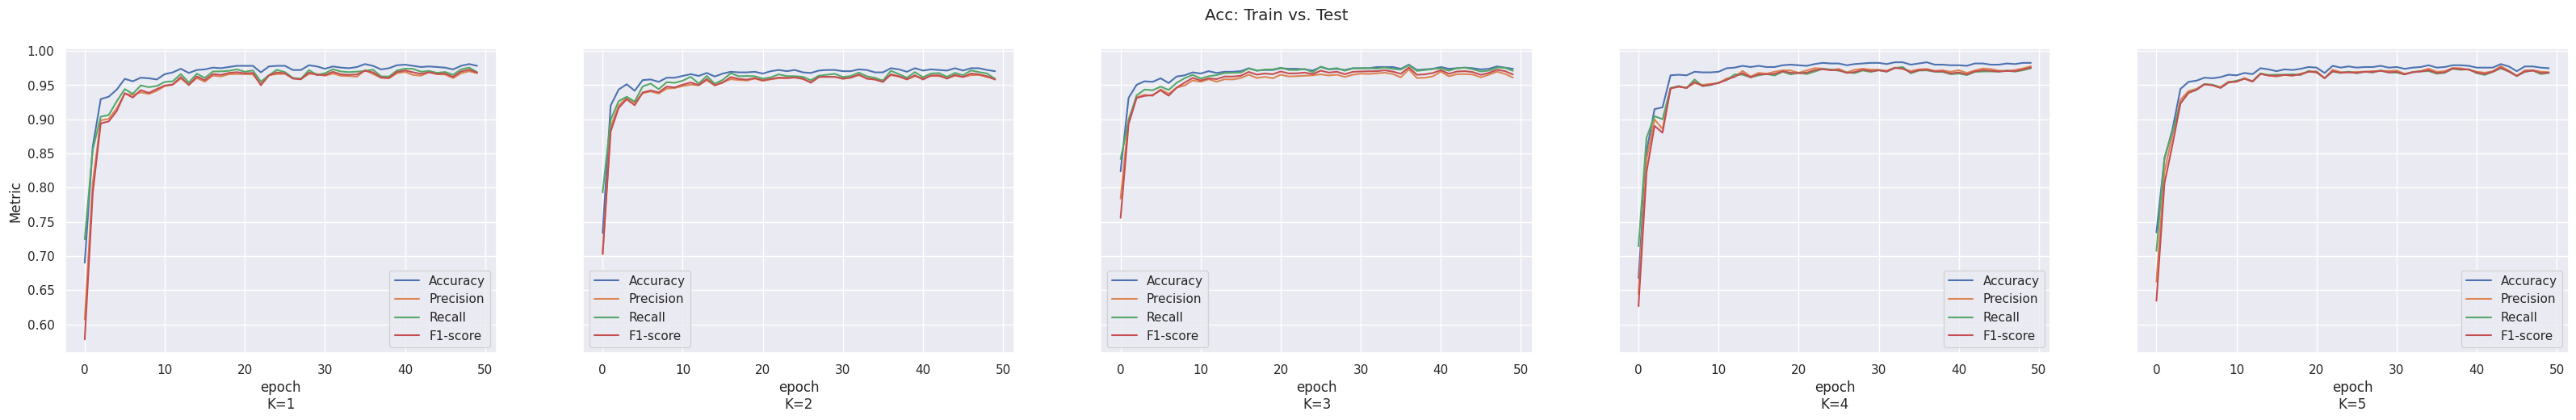

In [36]:
fig, axes = plt.subplots(1, k, figsize=(40, 5), sharey=True)
fig.suptitle('Acc: Train vs. Test')

i=0
for i in range(k):
    res= sns.lineplot(
            ax=axes[i],
            data=[
                folds[i].test_accuracy,
                folds[i].test_precision,            
                folds[i].test_recall,
                folds[i].test_f1_score
            ],
            markers=False, 
            dashes=False,   
            )
    
    res.set(xlabel='epoch\nK={:d}'.format(i+1), ylabel='Metric')
    res.legend(labels=["Accuracy","Precision","Recall","F1-score"])  

In [37]:
print("{:0.10f};{:0.10f};{:0.10f};{:0.10f}".format(np.mean(total_accuracy),np.mean(total_precision),np.mean(total_recall),np.mean(total_f1_score)))


0.9760416667;0.9670217519;0.9684051112;0.9672538198


<AxesSubplot:>

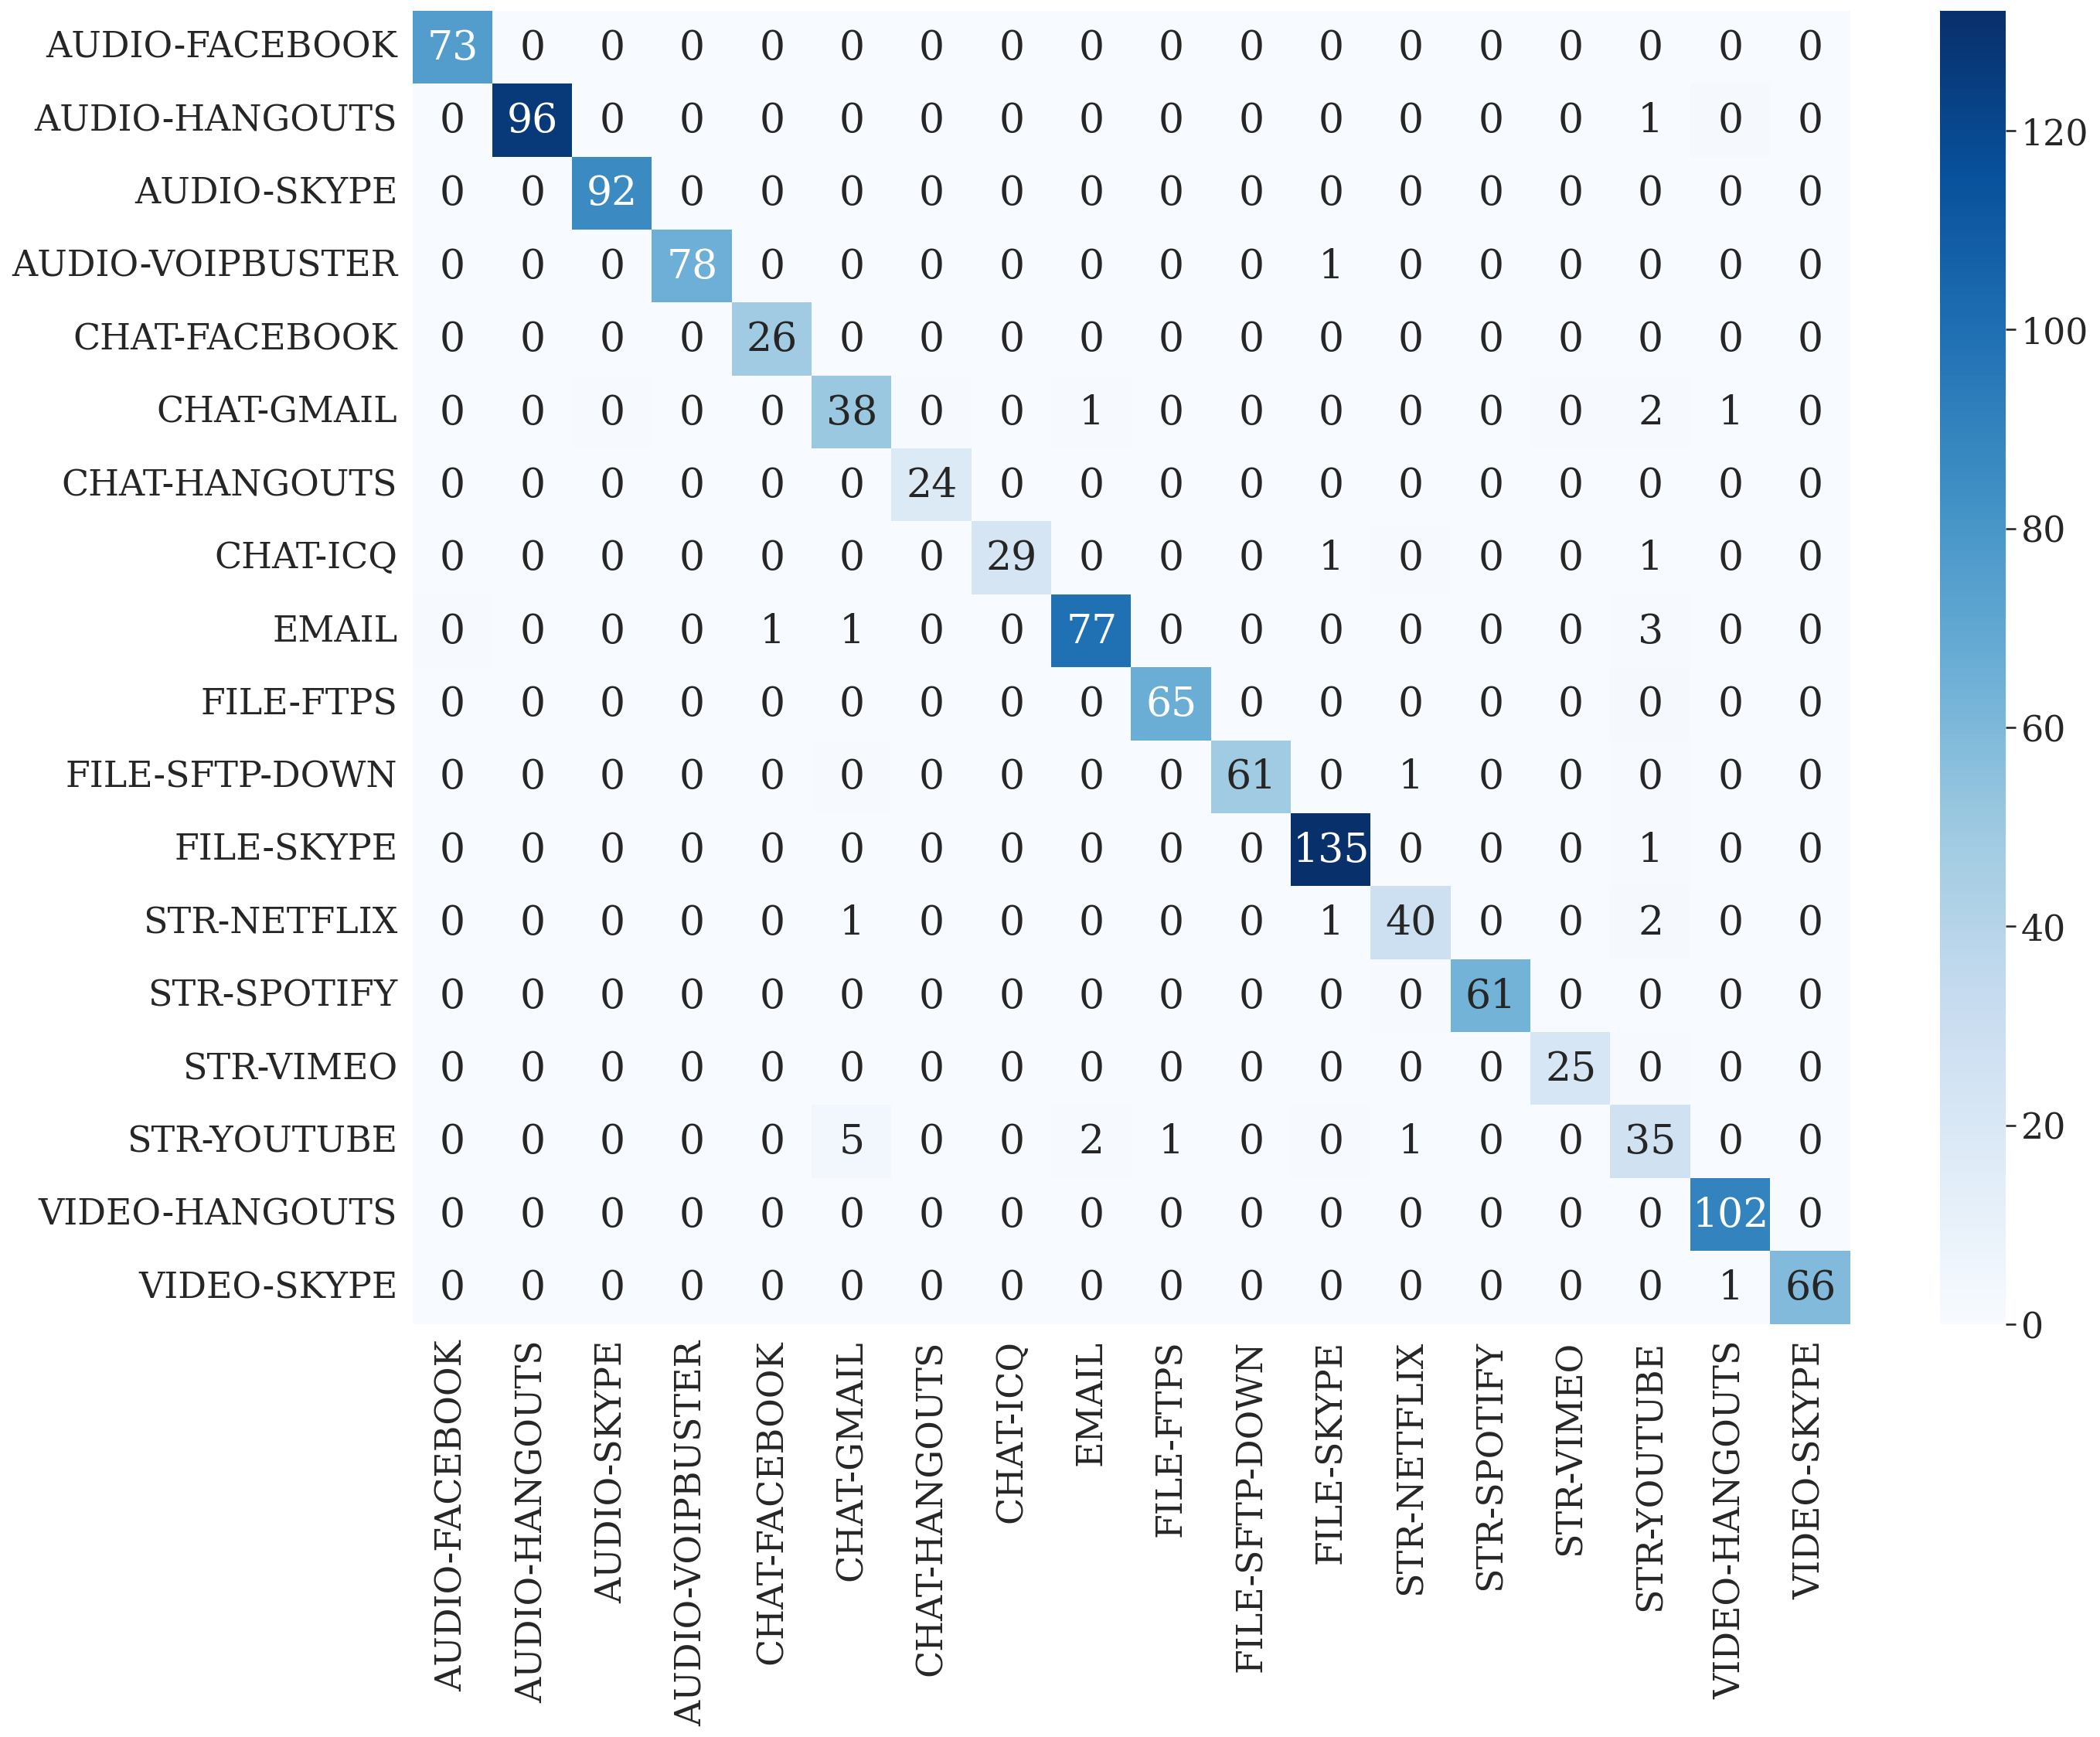

In [38]:
i=4
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})

sns.set_context('notebook')
sns.set_style("darkgrid")

sns.set(font_scale=2,rc={"figure.figsize":(8, 4)})
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

plt.figure(figsize=(20, 15))
plt.xlabel("Folds")

plt.ylabel("score")

sns.heatmap(folds[0].confusion_matrix,annot=folds[i].confusion_matrix,xticklabels=classe_label,
            yticklabels=classe_label,
            cmap="Blues",
            annot_kws={'size': 25},
            fmt='g')

In [40]:
last_true_all = np.array([], dtype=int) 
last_pred_all = np.array([], dtype=int) 
last_score_all = np.empty((0,n_classes), float)


i=0
for i in range(k):
    last_true_all  = np.append(last_true_all,folds[i].last_true)
    last_pred_all  = np.append(last_pred_all,folds[i].last_pred)
    
    last_score_all = np.append(last_score_all,folds[i].last_score,axis=0)
    
    
i=4
j=0
n_samples= last_true_all.shape[0]
x = torch.Tensor(last_true_all)

labels = [random.randrange(n_classes) for _ in range(n_samples)]

labels_tensor = torch.as_tensor(labels)

y_one_hot = torch.nn.functional.one_hot(x.to(torch.int64),  num_classes=n_classes)




fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_one_hot[:, i],last_score_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

fpr["micro"], tpr["micro"], _ = roc_curve(y_one_hot.ravel(), last_score_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

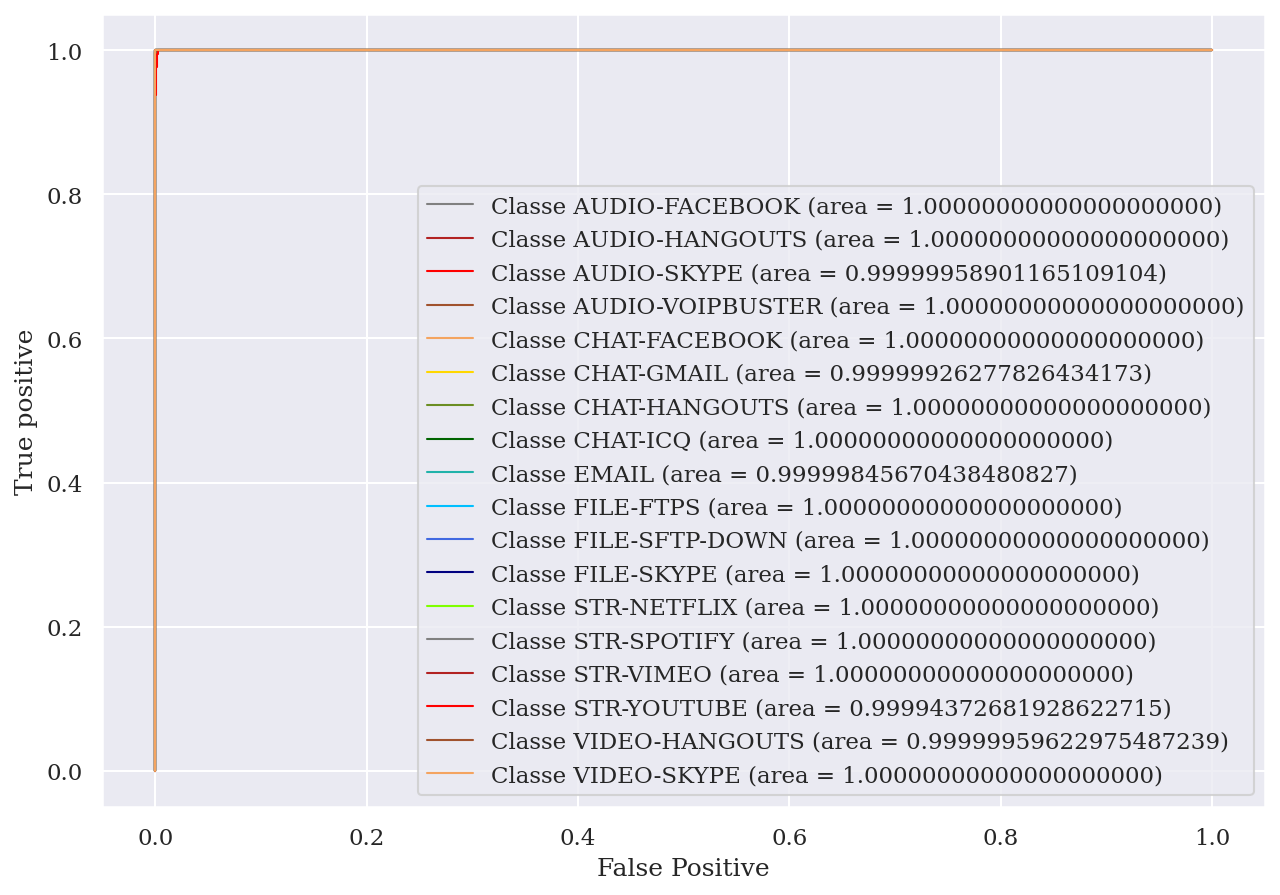

In [42]:
lw = 1 


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])


mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.figure(figsize=(10,7))


colors = cycle(['gray','firebrick','red','sienna','sandybrown', 'gold',
                'olivedrab','darkgreen','lightseagreen','deepskyblue','royalblue','navy',
                'chartreuse'
               ])
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(6, 4)})
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='Classe {0} (area = {1:0.20f})'
             ''.format(classe_label[i], roc_auc[i]))
    
 
plt.xlabel('False Positive')
plt.ylabel('True positive')

plt.legend(loc="lower right")
plt.show()